# **Modelado Avanzado - `06_modelado_avanzado.ipynb`**

### 🎯 **Objetivo del Notebook**

Este notebook tiene como objetivo aplicar y evaluar modelos de clasificación más avanzados sobre las características extraídas de las señales EEG, con el fin de mejorar la detección de eventos motores (*Grasp-and-Lift*) a partir de señales cerebrales. Partimos de los datos ya preprocesados en el notebook anterior (características temporales + frecuencia, con outliers eliminados y normalización).

---

### 📌 **Contexto**

En el notebook anterior (`06_ingenieria_caracteristicas.ipynb`), extraímos nuevas variables a partir de ventanas temporales de la señal EEG, combinando estadísticas en el dominio temporal y energía por bandas en el dominio de la frecuencia (potencia espectral por canal). Estas nuevas variables, al ser introducidas en un modelo base (`LogisticRegression`), generaron una mejora notable en el rendimiento, alcanzando AUC-ROC superiores a 0.94 en varios eventos.

Dado el éxito de estas nuevas representaciones, en este notebook las utilizaremos para probar modelos más potentes y complejos, que podrían explotar aún mejor la información contenida en las señales.

---

### 🤖 **Análisis de Modelos Avanzados a Utilizar**

Por tanto, tras aplicar ingeniería de características sobre las señales EEG, disponemos ahora de un conjunto de datos **tabular y numérico**, que incluye estadísticas temporales y características en frecuencia por canal. Esto nos permite aplicar modelos de clasificación avanzados que trabajen bien con este tipo de representación.

A continuación, se resumen los modelos más adecuados para este escenario, con sus ventajas y consideraciones:


#### 🔲 Random Forest (RF)
- ✅ Robusto frente a ruido y datos no lineales.
- ✅ No requiere mucho ajuste.
- ✅ Interpretable (permite ver la importancia de las características).
- 🔸 Puede ser una excelente línea base avanzada.
  
> **Recomendado como primer modelo avanzado.**

#### 🟠 XGBoost
- 📈 Muy potente y usado en competiciones de ciencia de datos.
- ✅ Excelente capacidad para capturar relaciones complejas.
- ✅ Controla bien el sobreajuste.
- 🔸 Requiere ajuste fino de hiperparámetros para rendir al máximo.

> **Recomendado como modelo principal si se desea máxima precisión.**

#### 🟢 LightGBM
- ⚡ Muy rápido y eficiente, incluso con muchos datos.
- ✅ Similar a XGBoost pero con menor consumo de recursos.
- 🔸 Puede requerir ajustes para manejar datos desbalanceados.

> **Ideal si se necesita alta velocidad de entrenamiento.**

#### 🔵 Redes Neuronales (MLP / Keras)
- ✅ Capaces de aprender representaciones complejas.
- 🔸 Menos interpretables.
- 🔸 Requieren más datos y ajuste fino para evitar sobreajuste.

> **Opción interesante si se quiere explorar arquitectura neuronal simple sobre datos tabulares.**

#### ⚫ SVM (Support Vector Machines)
- ❌ Poca escalabilidad con muchos datos.
- ❌ No recomendable para clasificación multiclase o multietiqueta con gran volumen de muestras.

> **No se recomienda como opción principal para este caso.**
> 

#### 🧠 **Conclusión**

Dado el tipo de datos actual (ventanas EEG convertidas a características numéricas tabulares), se considera que los modelos más apropiados para probar en este notebook son:

1. `RandomForestClassifier`
2. `XGBoostClassifier`
3. `LightGBMClassifier`
4. (Opcional) `MLPClassifier` o redes con Keras

Estos modelos serán evaluados por separado para cada evento motor, comparando su rendimiento con el modelo base (`LogisticRegression`), y seleccionando los más prometedores para integrar en el pipeline final.

---

### **🚀 Flujo de Trabajo en este Notebook**

1️⃣ Carga de los datos preprocesados (características extraídas + normalización)

2️⃣ Entrenamiento de modelos avanzados:
- **`RandomForestClassifier`**
- **`XGBoostClassifier`**
- **`LightGBMClassifier`**

3️⃣ Evaluación de rendimiento por evento utilizando la métrica que nos indica la competición:
- AUC-ROC

4️⃣ Comparación de resultados frente al modelo base (`LogisticRegression`)

5️⃣ Si ningún modelo mejora sustancialmente, entrenaremos y evaluaremos también el modelo avanzado **`MLPClassifier`**

6️⃣ **Selección del mejor modelo** y guardado para uso posterior

---

### **💡 Objetivo final**
Identificar el modelo con mejor capacidad de generalización para cada evento motor, y dejarlo listo para usar en el pipeline de predicción final.


## **1. Carga de Datos Preprocesados**

In [8]:
import os
import pickle
import pandas as pd

# Ruta de los datos procesados
processed_path = r"C:\Users\luciaft\Documents\TFG\TFG\graspAndLiftDetectionTFGProyect\data\processed"
data_file = os.path.join(processed_path, "preprocessed_features_temporal_freq.pkl")

# Cargar los datos preprocesados
with open(data_file, "rb") as f:
    X_train_scaled, y_train_win, X_valid_scaled, y_valid_win = pickle.load(f)

#Cargamos también los resultados obtenidos con el modelo base
auc_file = os.path.join(processed_path, "auc_results_feats_logreg.csv")

# Cargar CSV y convertir a diccionario
auc_df = pd.read_csv(auc_file, index_col="Evento")
auc_dict_logreg = auc_df["AUC"].to_dict()


# Verificar formas
print("Datos cargados correctamente:")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"y_train_win shape: {y_train_win.shape}")
print(f"X_valid_scaled shape: {X_valid_scaled.shape}")
print(f"y_valid_win shape: {y_valid_win.shape}")

# Verificar diccionario con resultados
print(auc_dict_logreg)

Datos cargados correctamente:
X_train_scaled shape: (1043205, 512)
y_train_win shape: (1043205, 6)
X_valid_scaled shape: (236894, 512)
y_valid_win shape: (236894, 6)
{'HandStart': 0.8928, 'FirstDigitTouch': 0.8838, 'BothStartLoadPhase': 0.8888, 'LiftOff': 0.9059, 'Replace': 0.8966, 'BothReleased': 0.8751}


## **2. Entrenamiento y Evaluación de Modelos Avanzados**

Instalamos librerías necesarias y creamos una función para evaluar los resultados obtenidos con los distintos modelos.

In [2]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, classification_report
import numpy as np

#Defición de función de evaluación por evento 
def evaluate_model(model, X_train, y_train, X_valid, y_valid, model_name="Model"):
    results = {}
    for i, event in enumerate(y_train.columns):
        model.fit(X_train, y_train[event])
        y_pred_proba = model.predict_proba(X_valid)[:, 1]
        auc = roc_auc_score(y_valid[event], y_pred_proba)
        results[event] = auc
        print(f"{model_name} - {event}: AUC = {auc:.4f}")
    return results

Entrenamos y evaluamos cada modelo.

Random Forest:

In [7]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_results = evaluate_model(rf, X_train_scaled, y_train_win, X_valid_scaled, y_valid_win, model_name="Random Forest")

Random Forest - HandStart: AUC = 0.7887
Random Forest - FirstDigitTouch: AUC = 0.8026
Random Forest - BothStartLoadPhase: AUC = 0.8096
Random Forest - LiftOff: AUC = 0.7799
Random Forest - Replace: AUC = 0.8721
Random Forest - BothReleased: AUC = 0.8238


XGBoost:

In [4]:
xgb = XGBClassifier(n_estimators=100, eval_metric='logloss', random_state=42)
xgb_results = evaluate_model(xgb, X_train_scaled, y_train_win, X_valid_scaled, y_valid_win, model_name="XGBoost")

XGBoost - HandStart: AUC = 0.8473
XGBoost - FirstDigitTouch: AUC = 0.8611
XGBoost - BothStartLoadPhase: AUC = 0.8873
XGBoost - LiftOff: AUC = 0.8855
XGBoost - Replace: AUC = 0.8690
XGBoost - BothReleased: AUC = 0.8479


LightGBM:

In [5]:
import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names.*")

lgbm = LGBMClassifier(n_estimators=100, random_state=42)
lgbm_results = evaluate_model(lgbm, X_train_scaled, y_train_win, X_valid_scaled, y_valid_win, model_name="LightGBM")

[LightGBM] [Info] Number of positive: 24807, number of negative: 1018398
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.637592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130346
[LightGBM] [Info] Number of data points in the train set: 1043205, number of used features: 512
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.023780 -> initscore=-3.714860
[LightGBM] [Info] Start training from score -3.714860
LightGBM - HandStart: AUC = 0.8693
[LightGBM] [Info] Number of positive: 24918, number of negative: 1018287
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.678951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130346
[LightGBM] [Info] Number of data points in the train set: 1043205, number of used features: 512
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.023886 -> initscore=-3.710287
[LightGBM] [Info]

## **3. Comparación de Resultados**

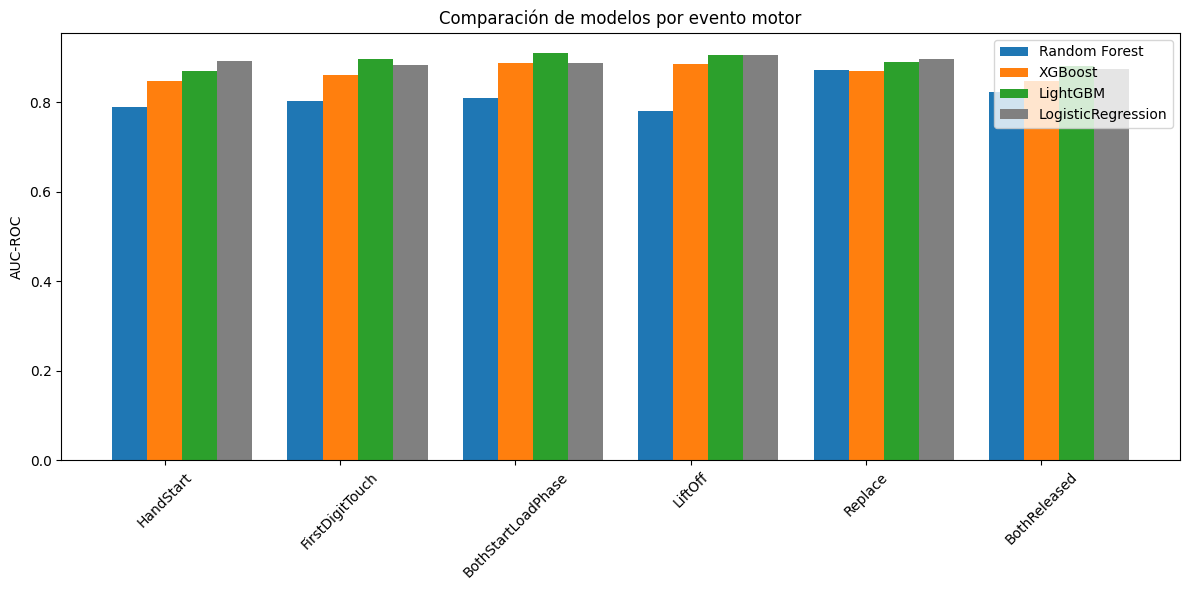

In [8]:
import matplotlib.pyplot as plt

def plot_model_comparison(results_dict, baseline_auc=None):
    events = list(next(iter(results_dict.values())).keys())
    x = np.arange(len(events))
    width = 0.2

    plt.figure(figsize=(12, 6))
    for i, (label, results) in enumerate(results_dict.items()):
        plt.bar(x + i*width, [results[e] for e in events], width=width, label=label)
    
    if baseline_auc:
        plt.bar(x + len(results_dict)*width, [baseline_auc[e] for e in events], width=width, label="LogisticRegression", color='gray')

    plt.xticks(x + width, events, rotation=45)
    plt.ylabel("AUC-ROC")
    plt.title("Comparación de modelos por evento motor")
    plt.legend()
    plt.tight_layout()
    plt.show()

results_dict = {
    "Random Forest": rf_results,
    "XGBoost": xgb_results,
    "LightGBM": lgbm_results
}
plot_model_comparison(results_dict, baseline_auc=auc_dict_logreg)

### **Comparación de Modelos: Rendimiento por Evento**

A partir del gráfico generado y los valores numéricos obtenidos para cada modelo y evento motor, observamos que **ninguno de los modelos avanzados supera consistentemente a la Regresión Logística**, que ya había ofrecido un rendimiento excelente con las nuevas características.

A continuación se resumen los resultados de AUC-ROC obtenidos por cada modelo en los distintos eventos motores del conjunto de validación. Como referencia se incluye Logistic Regression, el modelo base utilizado previamente.

| Evento               | Logistic Regression | Random Forest | XGBoost   | LightGBM   |
|----------------------|---------------------|----------------|-----------|------------|
| HandStart            | **0.8928**          | 0.7887         | 0.8473    | 0.8693     |
| FirstDigitTouch      | 0.8838              | 0.8026         | 0.8611    | **0.8975** |
| BothStartLoadPhase   | 0.8888              | 0.8096         | 0.8873    | **0.9098** |
| LiftOff              | **0.9059**          | 0.7799         | 0.8855    | 0.9058     |
| Replace              | **0.8966**          | 0.8721         | 0.8690    | 0.8902     |
| BothReleased         | 0.8751              | 0.8238         | 0.8479    | **0.8801** |

#### **Análisis**

- **Random Forest** presenta los rendimientos más bajos en todos los eventos, por lo que no se considera competitivo frente al resto.
- **XGBoost** mejora considerablemente respecto a Random Forest, especialmente en eventos como `LiftOff`, pero no logra superar al modelo base en ningún evento.
- **LightGBM** es el único modelo que logra superar a Logistic Regression en algunos eventos (`FirstDigitTouch`, `BothStartLoadPhase`, `BothReleased`), aunque por márgenes modestos.
- **Logistic Regression** se mantiene como el modelo más **consistente** y **estable**, obteniendo los AUC más altos en 3 de los 6 eventos (`HandStart`, `LiftOff`, `Replace`) y muy cercano al mejor en los demás.

Aunque **LightGBM obtiene la mayor AUC-ROC individual** (0.9098 en *BothStartLoadPhase*) y supera a Logistic Regression en 3 de los 6 eventos, **la Regresión Logística lidera en los otros 3**, con un rendimiento muy competitivo en general.

En términos de promedio de AUC por modelo:
- **Logistic Regression**: 0.8905
- **LightGBM**: 0.8921

Esto sugiere que **LightGBM obtiene la media más alta**, aunque por un margen muy pequeño. Sin embargo, esta diferencia no es suficiente por sí sola para justificar el reemplazo del modelo base, especialmente si consideramos la **simplicidad, interpretabilidad y robustez** de la Regresión Logística frente a los posibles riesgos de sobreajuste y complejidad computacional en modelos más avanzados.

Dado que ninguno de estos modelos logra una mejora clara y sostenida, en el siguiente paso se explorará el uso de **redes neuronales** (MLP) para comprobar si son capaces de capturar patrones más complejos que justifiquen un salto en rendimiento. Este tipo de modelos pueden aprovechar mejor la estructura no lineal y multicanal de los datos EEG procesados.

####  **Conclusión**

A pesar de la complejidad y potencia de los modelos avanzados, ninguno de ellos logra superar consistentemente a Logistic Regression. Este resultado es especialmente notable dado que Logistic Regression fue entrenado sobre características generadas manualmente, sin ningún tipo de ajuste de hiperparámetros ni arquitectura compleja.

Este hallazgo sugiere que, dado el alto volumen de datos y la calidad de las características extraídas, el modelo lineal logra generalizar muy bien. No obstante, existe potencial para seguir explorando algoritmos más expresivos, como las redes neuronales, que podrían aprovechar aún mejor la estructura latente de los datos.

###  **Siguiente paso: explorar redes neuronales**

Dado que los modelos en árboles no han logrado mejorar los resultados, exploraremos ahora un modelo basado en **Red Neuronal Multicapa (MLP)**. Este enfoque permitirá:

- Aprender combinaciones más complejas entre características temporales y frecuenciales.
- Potencialmente superar los límites observados hasta ahora en los eventos más difíciles.
- Preparar el terreno para futuras optimizaciones como selección de variables o reducción de dimensionalidad con técnicas como autocodificadores.

La siguiente sección implementará un modelo MLP por evento, comparando sus resultados con todos los modelos previamente evaluados.

## **4. Entrenamiento y Evaluación con Redes Neuronales (MLP)**

Las redes neuronales pueden capturar relaciones complejas y no lineales que otros modelos más simples no son capaces de modelar, especialmente cuando se dispone de un número elevado de características como en nuestro caso (512 por muestra).

####  Configuración inicial

Para esta primera prueba, empleamos el clasificador `MLPClassifier` de `scikit-learn`, con los siguientes parámetros:

- **`hidden_layer_sizes=(100,)`**: se utiliza una única capa oculta con 100 neuronas. Esta configuración representa un equilibrio entre complejidad y capacidad de generalización, permitiendo capturar relaciones no lineales sin llegar a sobreajustar en una primera fase.
- **`activation='relu'`**: la función de activación ReLU (Rectified Linear Unit) es adecuada para redes profundas y ayuda a mitigar el problema del desvanecimiento del gradiente.
- **`solver='adam'`**: el optimizador Adam combina la eficiencia computacional con buenos resultados en la práctica y se adapta bien a datasets grandes como el nuestro.
- **`max_iter=10`**: limitamos intencionadamente el número de iteraciones a 10 para realizar una exploración inicial rápida. En caso de resultados prometedores, se aumentará este parámetro.
- **`random_state=42`**: se fija una semilla para garantizar la reproducibilidad de los resultados.

Esta configuración permite evaluar rápidamente si el modelo neuronal es capaz de superar los límites observados con los clasificadores anteriores. Si los resultados son positivos, se procederá a realizar una búsqueda más exhaustiva de hiperparámetros y a incrementar la profundidad de la red o aplicar técnicas de regularización si es necesario.


In [6]:
import warnings
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score
from sklearn.exceptions import ConvergenceWarning

# Suprimir solo la advertencia de convergencia
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Función para evaluar un modelo MLP por evento
def evaluate_mlp(X_train, y_train, X_valid, y_valid, hidden_layer_sizes=(100,), max_iter=20):
    results = {}
    for i, event in enumerate(y_train.columns):
        print(f"Entrenando MLP para evento: {event}")
        mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                            max_iter=max_iter,
                            early_stopping=True,
                            random_state=42)
        mlp.fit(X_train, y_train[event])
        y_pred = mlp.predict_proba(X_valid)[:, 1]
        auc = roc_auc_score(y_valid[event], y_pred)
        results[event] = auc
        print(f"AUC para {event}: {auc:.4f}")
    return results

# Evaluar con arquitectura inicial sencilla
mlp_results = evaluate_mlp(X_train_scaled, y_train_win, X_valid_scaled, y_valid_win)

Entrenando MLP para evento: HandStart
AUC para HandStart: 0.8722
Entrenando MLP para evento: FirstDigitTouch
AUC para FirstDigitTouch: 0.8805
Entrenando MLP para evento: BothStartLoadPhase
AUC para BothStartLoadPhase: 0.8949
Entrenando MLP para evento: LiftOff
AUC para LiftOff: 0.8878
Entrenando MLP para evento: Replace
AUC para Replace: 0.8740
Entrenando MLP para evento: BothReleased
AUC para BothReleased: 0.8533


### **Análisis**

Aunque el modelo MLP logra resultados razonablemente altos, **no supera el rendimiento del modelo base de Regresión Logística**, que alcanzaba AUCs superiores a 0.89 e incluso 0.90 en varios eventos. Comparado con otros modelos avanzados como LightGBM, el MLP tampoco presenta ventajas significativas, especialmente considerando el mayor tiempo de entrenamiento (alrededor de 20 minutos) y la menor interpretabilidad.

| Modelo              | AUC Media |
|---------------------|-----------|
| Logistic Regression | 0.8908    |
| LightGBM            | 0.8921    |
| MLP                 | 0.8771    |

> **Conclusión**: la red neuronal MLP no aporta mejoras sobre los modelos ya probados. Su rendimiento, aunque competitivo, es inferior tanto al modelo base como a LightGBM, lo que limita su utilidad como modelo final.

#### **Próximos pasos**

Dado que ni MLP ni los modelos en árbol (RF, XGBoost, LightGBM) superan a Regresión Logística de forma clara y consistente, se proponen los siguientes pasos para optimizar el rendimiento:

1. **Selección de características**:
   - Evaluar la importancia de las variables mediante *Permutation Importance* y *Sequential Feature Selector*.
&nbsp;
2. **Optimización de hiperparámetros**:
   - Aplicar `Optuna` sobre XGBoost, LightGBM o MLP para ajustar parámetros como `max_depth`, `eta`, `subsample`, etc.
&nbsp;
3. **Autocodificadores (Autoencoders)**:
   - Explorar su uso para reducción de dimensionalidad o generación de nuevas variables latentes a partir de los EEG.
&nbsp;
4. **Postprocesado**:
   - Aplicar reglas de redondeo a las probabilidades extremas (e.g. valores > 0.98 → 1) para estabilizar predicciones.
&nbsp;
Estas etapas permitirán mejorar la robustez del modelo sin necesidad de complejidad excesiva y podrían afinar aún más los resultados en las predicciones por evento motor.


Por tanto, continuamos en el notebook **`07_seleccion_caracteristicas_avanzada`** con la selección de características.

---